# Data Preparation 

In [1]:
import numpy as np
from glob import glob
from PIL import Image
from sklearn.model_selection import train_test_split
import random

# Define paths to the dataset
dataset_path = '/Users/harshrajmishra/Documents/Lakshitha Fr/Kvasir-SEG'
images_path = f'{dataset_path}/images/'
masks_path = f'{dataset_path}/masks/'

# Load dataset file paths
image_files = sorted(glob(images_path + '*.jpg'))
mask_files = sorted(glob(masks_path + '*.jpg'))

print("Dataset loaded successfully.")
print(f"Total images: {len(image_files)}")
print(f"Total masks: {len(mask_files)}")

# Simplified balancing function (random oversampling)
def balance_dataset(image_paths, mask_paths):
    max_size = max(len(image_paths), len(mask_paths))
    balanced_img_paths = random.choices(image_paths, k=max_size)
    balanced_mask_paths = random.choices(mask_paths, k=max_size)
    return balanced_img_paths, balanced_mask_paths

# Balance the dataset
balanced_image_files, balanced_mask_files = balance_dataset(image_files, mask_files)

# Split dataset into training, validation, and test sets
# First split: separate 20% of data for testing
train_val_imgs, test_imgs, train_val_masks, test_masks = train_test_split(balanced_image_files, balanced_mask_files, test_size=0.2, random_state=42)

# Second split: divide the remaining 80% of data into 75% training and 25% validation (which is 60% and 20% of the total dataset, respectively)
train_imgs, val_imgs, train_masks, val_masks = train_test_split(train_val_imgs, train_val_masks, test_size=0.25, random_state=42) # 0.25 * 0.8 = 0.2

print("Dataset split into training, validation, and test sets:")
print(f"- Training images: {len(train_imgs)}")
print(f"- Validation images: {len(val_imgs)}")
print(f"- Test images: {len(test_imgs)}")

def load_image(path, target_size=(256, 256), grayscale=False):
    """Load an image from a file path and resize it."""
    img = Image.open(path)
    img = img.resize(target_size)
    if grayscale:
        img = img.convert('L')  # Convert to grayscale
    img = np.array(img, dtype=np.float32)
    img /= 255.0  # Normalize to [0, 1]
    return img

def preprocess_dataset(image_paths, mask_paths):
    """Load and preprocess a list of image and mask paths."""
    images = [load_image(path) for path in image_paths]
    masks = [load_image(path, grayscale=True, target_size=(256, 256)) for path in mask_paths]
    masks = np.expand_dims(masks, axis=-1)  # Add channel dimension for masks
    print(f"Processed {len(images)} images and {len(masks)} masks.")
    return np.array(images), np.array(masks)

# Preprocess training, validation, and test datasets
train_images, train_masks = preprocess_dataset(train_imgs, train_masks)
val_images, val_masks = preprocess_dataset(val_imgs, val_masks)
test_images, test_masks = preprocess_dataset(test_imgs, test_masks)

print("Datasets preprocessed and balanced successfully. Ready for model training and evaluation.")


Dataset loaded successfully.
Total images: 1000
Total masks: 1000
Dataset split into training, validation, and test sets:
- Training images: 600
- Validation images: 200
- Test images: 200
Processed 600 images and 600 masks.
Processed 200 images and 200 masks.
Processed 200 images and 200 masks.
Datasets preprocessed and balanced successfully. Ready for model training and evaluation.


In [2]:
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def mean_iou(y_true, y_pred, num_classes=2):
    miou = tf.keras.metrics.MeanIoU(num_classes=num_classes)
    miou.update_state(y_true, y_pred)
    return miou.result().numpy()

# MFSNet Model

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, UpSampling2D, BatchNormalization, Activation, Conv2DTranspose, Dropout, Add, Multiply
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt

def attention_block(x, g, inter_channel):
    theta_x = Conv2D(inter_channel, [1, 1], strides=[2, 2], padding='same')(x)
    phi_g = Conv2D(inter_channel, [1, 1], padding='same')(g)
    concat = Add()([theta_x, phi_g])
    act = Activation('relu')(concat)
    psi = Conv2D(1, [1, 1], padding='same')(act)
    sigmoid = Activation('sigmoid')(psi)
    upsample_psi = UpSampling2D(size=(2, 2))(sigmoid)
    y = Multiply()([upsample_psi, x])
    return y

def build_mfsnet_model(input_shape=(256, 256, 3), L=0.001):
    inputs = Input(input_shape)
    
    # Encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    # Bottleneck
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    
    # Attention Mechanism
    attention1 = attention_block(conv1, conv2, 32)
    
    # Decoder
    up1 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv2)
    merge1 = concatenate([attention1, up1], axis=-1)
    conv3 = Conv2D(32, (3, 3), activation='relu', padding='same')(merge1)
    conv3 = BatchNormalization()(conv3)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv3)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer=Adam(learning_rate=L), loss='binary_crossentropy', metrics=['accuracy', dice_coef])
    
    return model


# Model training without data augmentation

In [4]:
# Model training without data augmentation
model_no_aug = build_mfsnet_model(L=0.01)  
history_no_aug = model_no_aug.fit(train_images, train_masks, validation_data=(val_images, val_masks), epochs=10, batch_size=64)

Epoch 1/10
10/10 [==============================] - 67s 6s/step - loss: 0.7032 - accuracy: 0.6329 - dice_coef: 0.2345 - val_loss: 0.6876 - val_accuracy: 0.5968 - val_dice_coef: 0.2496
Epoch 2/10
10/10 [==============================] - 65s 6s/step - loss: 0.4858 - accuracy: 0.8345 - dice_coef: 0.2173 - val_loss: 0.4986 - val_accuracy: 0.8233 - val_dice_coef: 0.2213
Epoch 3/10
10/10 [==============================] - 69s 7s/step - loss: 0.4272 - accuracy: 0.8391 - dice_coef: 0.1881 - val_loss: 0.4463 - val_accuracy: 0.8487 - val_dice_coef: 0.2177
Epoch 4/10
10/10 [==============================] - 78s 8s/step - loss: 0.4142 - accuracy: 0.8391 - dice_coef: 0.1718 - val_loss: 0.4492 - val_accuracy: 0.8236 - val_dice_coef: 0.2196
Epoch 5/10
10/10 [==============================] - 85s 9s/step - loss: 0.4128 - accuracy: 0.8391 - dice_coef: 0.1751 - val_loss: 0.4244 - val_accuracy: 0.8488 - val_dice_coef: 0.2074
Epoch 6/10
10/10 [==============================] - 126s 13s/step - loss: 0.4102

# Model training with data augmentation

In [5]:
# Model training with data augmentation
model_aug = build_mfsnet_model(L=0.001) 
data_gen_args = dict(rotation_range=20, width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

image_generator = image_datagen.flow(train_images, batch_size=32)
mask_generator = mask_datagen.flow(train_masks, batch_size=32)
train_generator = zip(image_generator, mask_generator)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

history_aug = model_aug.fit(train_generator, steps_per_epoch=len(train_images) / 32, epochs=10, validation_data=(val_images, val_masks), callbacks=[reduce_lr])


Epoch 1/10
18/18 [==============================] - 90s 5s/step - loss: 0.7006 - accuracy: 0.5331 - dice_coef: 0.2444 - val_loss: 0.6483 - val_accuracy: 0.8488 - val_dice_coef: 0.2258 - lr: 0.0010
Epoch 2/10
18/18 [==============================] - 98s 5s/step - loss: 0.6217 - accuracy: 0.6838 - dice_coef: 0.2413 - val_loss: 0.6106 - val_accuracy: 0.8488 - val_dice_coef: 0.2228 - lr: 0.0010
Epoch 3/10
18/18 [==============================] - 94s 5s/step - loss: 0.5808 - accuracy: 0.7887 - dice_coef: 0.2350 - val_loss: 0.5659 - val_accuracy: 0.8488 - val_dice_coef: 0.2155 - lr: 0.0010
Epoch 4/10
18/18 [==============================] - 85s 5s/step - loss: 0.5411 - accuracy: 0.8267 - dice_coef: 0.2323 - val_loss: 0.5397 - val_accuracy: 0.8488 - val_dice_coef: 0.2120 - lr: 0.0010
Epoch 5/10
18/18 [==============================] - 85s 5s/step - loss: 0.5077 - accuracy: 0.8313 - dice_coef: 0.2248 - val_loss: 0.5050 - val_accuracy: 0.8488 - val_dice_coef: 0.2059 - lr: 0.0010
Epoch 6/10
18/1

# Evaluation

7/7 [==============================] - 13s 2s/step
No Augmentation - Dice Coefficient: 0.1891413
No Augmentation - Mean IoU: 0.43026498
With Augmentation - Dice Coefficient: 0.16938108
With Augmentation - Mean IoU: 0.43026498


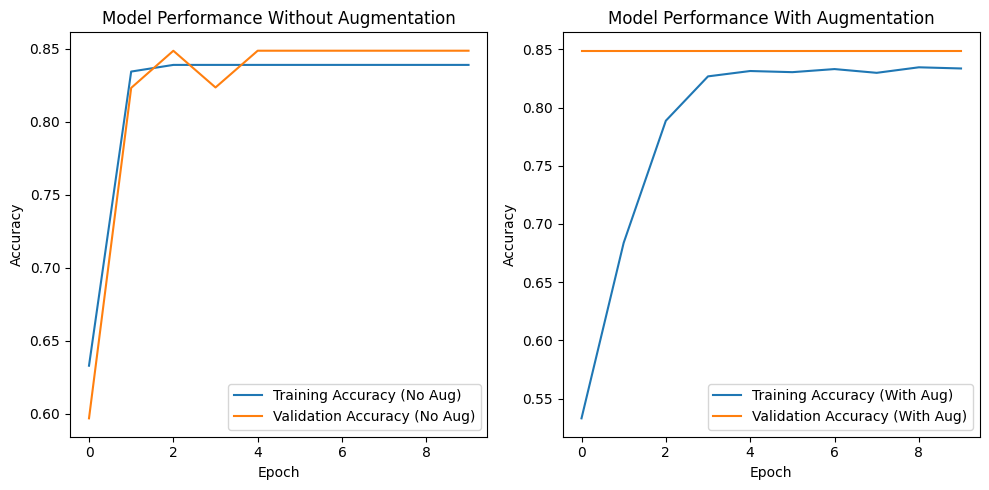

In [6]:
# Evaluation
val_preds_no_aug = model_no_aug.predict(val_images)
val_preds_aug = model_aug.predict(val_images)
print("No Augmentation - Dice Coefficient:", dice_coef(val_masks, val_preds_no_aug).numpy())
print("No Augmentation - Mean IoU:", mean_iou(val_masks, val_preds_no_aug))
print("With Augmentation - Dice Coefficient:", dice_coef(val_masks, val_preds_aug).numpy())
print("With Augmentation - Mean IoU:", mean_iou(val_masks, val_preds_aug))

# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history_no_aug.history['accuracy'], label='Training Accuracy (No Aug)')
plt.plot(history_no_aug.history['val_accuracy'], label='Validation Accuracy (No Aug)')
plt.title('Model Performance Without Augmentation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_aug.history['accuracy'], label='Training Accuracy (With Aug)')
plt.plot(history_aug.history['val_accuracy'], label='Validation Accuracy (With Aug)')
plt.title('Model Performance With Augmentation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()